# Exploratory Data Analysis

In [1]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import altair as alt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

In [2]:
df = pd.read_csv('video transcripts with topic.csv')
df.head()

Unnamed: 0                                         Transcript  \
0           0  Hi, welcome to Math Antics. In our last video,...   
1           1  We're asked to compute 3,060 divided by 36. We...   
2           2  in this video we're going to focus on adding a...   
3           3  alright guys grab your papers and pencils get ...   
4           4  hello great 9 students today we will talk abou...   

                        Topic  
0            Directed Numbers  
1  Operations of Whole Number  
2            Directed Numbers  
3                        Sets  
4          Algebra Expression

In [3]:
# check columns
df.columns

Index(['Unnamed: 0', 'Transcript', 'Topic'], dtype='object')

In [4]:
# drop Index Column
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  hello great 9 students today we will talk abou...   

                        Topic  
0            Directed Numbers  
1  Operations of Whole Number  
2            Directed Numbers  
3                        Sets  
4          Algebra Expression

In [6]:
# check for missing values in any column
df.isnull().any()

Transcript    False
Topic         False
dtype: bool

### Number of transcripts in each topic

In [7]:
bars = alt.Chart(df).mark_bar(size=50).encode(
    x=alt.X("Topic"),
    y=alt.Y("count():Q", axis=alt.Axis(title='Number of transcripts')),
    tooltip=[alt.Tooltip('count()', title='Number of transcripts'), 'Topic'],
    color='Topic'

)

text = bars.mark_text(
    align='center',
    baseline='bottom',
).encode(
    text='count()'
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "Number of transcripts in each category",
)

alt.LayerChart(...)

### % of transcripts in each topic

In [8]:
df['id'] = 1
df2 = pd.DataFrame(df.groupby('Topic').count()['id']).reset_index()

bars = alt.Chart(df2).mark_bar(size=50).encode(
    x=alt.X('Topic'),
    y=alt.Y('PercentOfTotal:Q', axis=alt.Axis(format='.0%', title='% of Transcripts')),
    color='Topic'
).transform_window(
    TotalArticles='sum(id)',
    frame=[None, None]
).transform_calculate(
    PercentOfTotal="datum.id / datum.TotalArticles"
)

text = bars.mark_text(
    align='center',
    baseline='bottom',
    #dx=5  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text=alt.Text('PercentOfTotal:Q', format='.1%')
)

(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of transcripts in each topic",
)

alt.LayerChart(...)

<b>The classes are approximately balanced.So, no need to oversampling or undersampling to balance the classes<b/>

### News length by topic

In [9]:
df.drop('id',axis=1,inplace=True)
df['Transcript Length'] = df['Transcript'].str.len()
df.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  hello great 9 students today we will talk abou...   

                        Topic  Transcript Length  
0            Directed Numbers              10411  
1  Operations of Whole Number               3949  
2            Directed Numbers               7868  
3                        Sets               6643  
4          Algebra Expression              76252

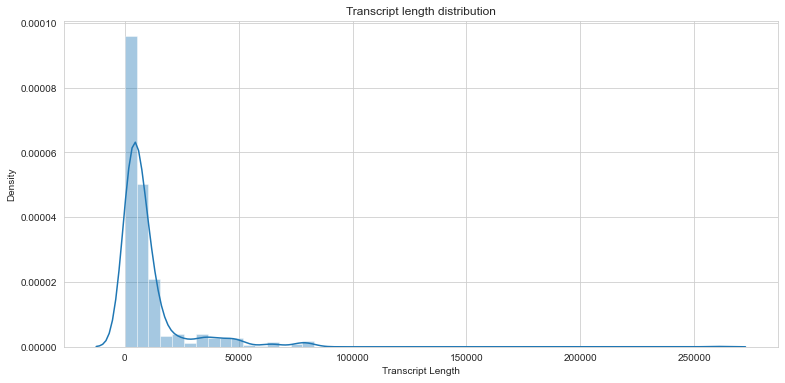

In [10]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['Transcript Length']).set_title('Transcript length distribution');

In [11]:
print(f'Dataset shape = {df.shape}')

Dataset shape = (897, 3)


<b> Take 5% - 95% percentiles to remove skewness. Then, it will be easy for training the model</b> 

In [12]:
quantile_5 = df['Transcript Length'].quantile(0.05)
quantile_95 = df['Transcript Length'].quantile(0.95)
df_1 = df[df['Transcript Length'] > quantile_5]
df_1 = df_1[df_1['Transcript Length'] < quantile_95]
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
5  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  
0            Directed Numbers              10411  
1  Operations of Whole Number               3949  
2            Directed Numbers               7868  
3                        Sets               6643  
5            Directed Numbers               1372

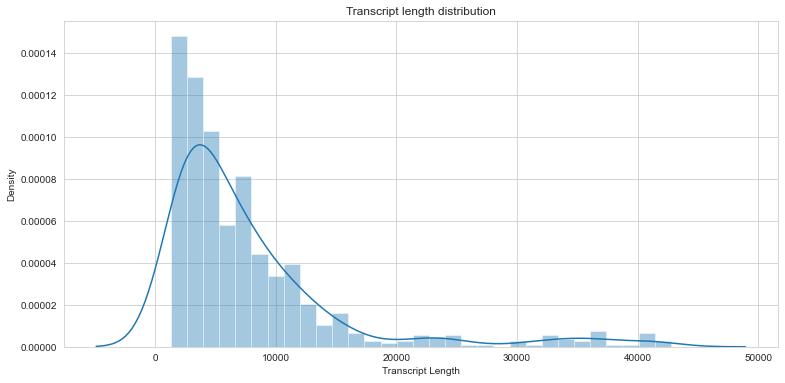

In [13]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Transcript Length']).set_title('Transcript length distribution');

In [14]:
print(f'Dataset shape = {df_1.shape}')

Dataset shape = (800, 3)


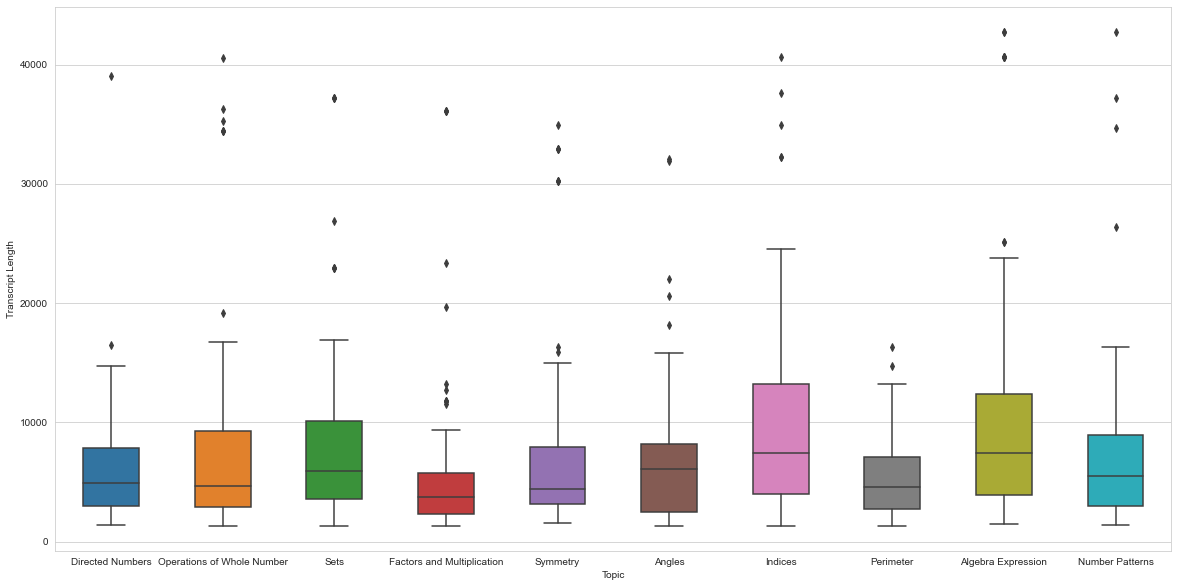

In [15]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_1, x='Topic', y='Transcript Length', width=.5);

<b> There are more outliers can see from the boxplot. So, I choosed a thereshold value for transcript length as 30,000 for all categories</b>

In [16]:
df_1 = df_1[df_1['Transcript Length'] <= 30000]
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
5  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  
0            Directed Numbers              10411  
1  Operations of Whole Number               3949  
2            Directed Numbers               7868  
3                        Sets               6643  
5            Directed Numbers               1372

In [17]:
print(f'Dataset shape = {df_1.shape}')

Dataset shape = (763, 3)


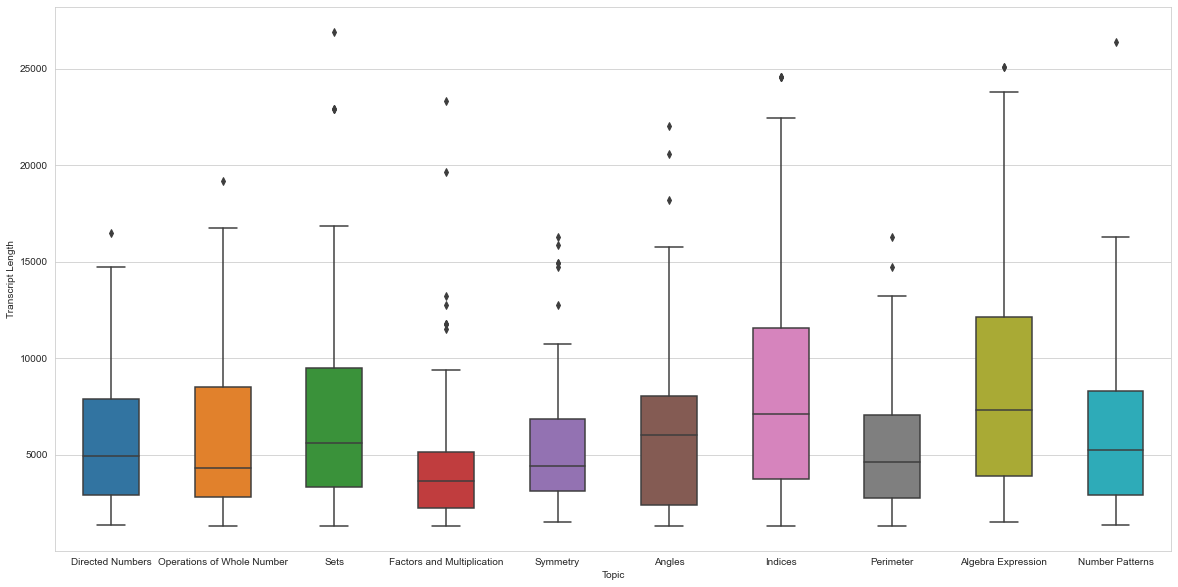

In [18]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df_1, x='Topic', y='Transcript Length', width=.5);

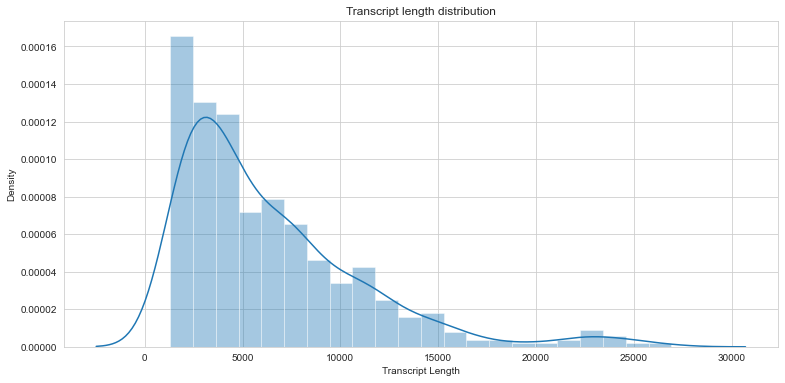

In [19]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Transcript Length']).set_title('Transcript length distribution');

# Feature Engineering

The next step is to create features from the raw text so we can train the machine learning models. The steps followed are:

1. **Text Cleaning and Preparation**: cleaning of special characters, downcasing, punctuation signs. possessive pronouns and stop words removal and lemmatization. 
2. **Label coding**: creation of a dictionary to map each category to a code.
3. **Train-test split**: to test the models on unseen data.
4. **Text representation**: use of TF-IDF scores to represent text.

## 1. Text cleaning and preparation

In [20]:
df_1.loc[1]['Transcript']

"We're asked to compute 3,060 divided by 36. We want to figure out how many times does 36-- I don't need to write it that big. We need to figure out how many times does 36 go into 3,060. Now, this is interesting because we're dividing by a two-digit number, by 36. We're going to see in this video that the process is the exact same way. There's just going to be a little bit more mental estimation going on, but we'll do it explicitly here, so hopefully, it won't be too bad. So we first look at 36, and we say, well, does 36 go into 3? Well, no. 3 is smaller than 36, so it won't go into 3. Does 36 go into 30? No, 30 is still smaller than 36, so it won't go into that. Does 36 go into 306? Well, sure. 306 is larger than 36, and if we were to estimate it, 30 would go into 300 ten times, but this is larger than 30, so it's going to go fewer times. Maybe it's 9. I'm not sure. Let's try it out. Let me try it out over on the side. What is 36 times 9? And this is kind of the art of doing these pro

### 1.1. Replace \n and \t

In [21]:
df_1['Transcript Parsed'] = df_1['Transcript'].str.replace("\r", " ")
df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.replace("\n", " ")

### 1.2. Convert to lowercase

In [22]:
df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.lower()

### 1.3. Remove punctuation signs

In [23]:
punctuation_signs = list("?:!.,;-$&^*%(){}[]/><@#~`|+_=“”…’−‘")
for punct_sign in punctuation_signs:
    df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.replace(punct_sign, '')

### 1.4. Remove possessive pronouns

In [24]:
df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.replace("'s", "")

### 1.5. Remove numbers

In [25]:
digits = list("1234567890")
for digit in digits:
    df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.replace(digit, '')

### 1.6. Remove single quote and double quote

In [26]:
df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.replace("'", "")
df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.replace('"', '')

### 1.7 Lemmatization

In [27]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

------------------------------------------------------------


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ameshmjayaweera/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ameshmjayaweera/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [29]:
nrows = len(df_1)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df_1.iloc[row]['Transcript Parsed']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [30]:
df_1['Transcript Parsed'] = lemmatized_text_list

In [31]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
5  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
5            Directed Numbers               1372   

                                   Transcript Parsed  
0  hi welcome to math antic in our last video we ...  
1  be ask to compute  divide by  we want to figur...  
2  in this video be go to focus on add and subtra...  
3  alright guy grab your paper and pencil get rea...  
5  with all of the rule and scenarios remember ho...

### 1.8. Remove Stop words

In [32]:
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ameshmjayaweera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
# Loading the stop words in english
stop_words = list(stopwords.words('english'))

In [34]:
stop_words[0:20]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [35]:
# remove stop words
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.replace(regex_stopword, '')

In [36]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
5  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
5            Directed Numbers               1372   

                                   Transcript Parsed  
0  hi welcome  math antic   last video  learn  ne...  
1   ask  compute  divide    want  figure   many t...  
2    video  go  focus  add  subtract integers    ...  
3  alright guy grab  paper  pencil get ready  pra...  
5      rule  scenarios remember   add  subtract n...

In [37]:
df_1.iloc[1]['Transcript Parsed']

' ask  compute  divide    want  figure   many time    dont need  write   big  need  figure   many time   go      interest   divide   twodigit number    go  see   video   process   exact  way   go    little bite  mental estimation go   well   explicitly   hopefully  wont   bad   first look     say well   go   well    smaller     wont go     go      still smaller     wont go     go   well sure   larger        estimate   would go   ten time    larger     go  go fewer time maybe   im  sure let try   let  try      side    time     kind   art    problems  youre divide  twodigit number  something   time    regroup  carry    time    plus   plus      time     still larger     go    go  less     go     eight time   go    go   eight time  remember  way  think     say  first guess  maybe  go  nine time    try   time    still larger    get   eight time  work    take  away      time   go  take us     away    another way  minus   go  get us    let try     make sure  time    put    carry    time    pl

### 1.9 Remove unnecessary spaces

In [38]:
df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.split()

In [39]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
5  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
5            Directed Numbers               1372   

                                   Transcript Parsed  
0  [hi, welcome, math, antic, last, video, learn,...  
1  [ask, compute, divide, want, figure, many, tim...  
2  [video, go, focus, add, subtract, integers, fi...  
3  [alright, guy, grab, paper, pencil, get, ready...  
5  [rule, scenarios, remember, add, subtract, neg...

In [40]:
df_1['Transcript Parsed'] = df_1['Transcript Parsed'].str.join(" ")

In [41]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
5  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
5            Directed Numbers               1372   

                                   Transcript Parsed  
0  hi welcome math antic last video learn negativ...  
1  ask compute divide want figure many time dont ...  
2  video go focus add subtract integers first hal...  
3  alright guy grab paper pencil get ready practi...  
5  rule scenarios remember add subtract negative ...

In [42]:
# check for missing values in any column
df_1.isnull().any()

Transcript           False
Topic                False
Transcript Length    False
Transcript Parsed    False
dtype: bool

### 1.10 Common Words

In [43]:
topics = list(df_1['Topic'].unique())
print(f'{topics}')

['Directed Numbers', 'Operations of Whole Number', 'Sets', 'Factors and Multiplication', 'Symmetry', 'Angles', 'Indices', 'Perimeter', 'Algebra Expression', 'Number Patterns']


In [44]:
topics_as_dict = dict()
for topic in topics:
    sentences_as_set = set()
    sentences = df_1[df_1['Topic'] == topic]['Transcript Parsed'].to_list()
    for sent in sentences:
        sentences_as_set.update(set(sent.split()))
    topics_as_dict[topic] = sentences_as_set

In [45]:
# find common words between all topics
common_words = topics_as_dict['Directed Numbers']
for topic,words_set in topics_as_dict.items():
    if topic == 'Directed Numbers':
        continue
    common_words = common_words.intersection(words_set)
    
print(f'Size of common words = {len(common_words)}')

Size of common words = 577


In [46]:
common_words

{'able',
 'absolutely',
 'accord',
 'across',
 'actual',
 'actually',
 'add',
 'addition',
 'ah',
 'ahead',
 'air',
 'almost',
 'along',
 'already',
 'alright',
 'also',
 'always',
 'angle',
 'another',
 'answer',
 'antic',
 'anything',
 'anyway',
 'apply',
 'area',
 'arent',
 'around',
 'arrange',
 'ask',
 'away',
 'b',
 'back',
 'bad',
 'ball',
 'bar',
 'base',
 'basic',
 'basically',
 'beautiful',
 'become',
 'begin',
 'behind',
 'believe',
 'best',
 'better',
 'big',
 'bigger',
 'birthday',
 'bite',
 'black',
 'blank',
 'blue',
 'board',
 'body',
 'book',
 'bottom',
 'box',
 'break',
 'bring',
 'build',
 'c',
 'calculate',
 'call',
 'cancel',
 'cannot',
 'cant',
 'care',
 'carefully',
 'carry',
 'case',
 'cat',
 'certain',
 'change',
 'channel',
 'chart',
 'check',
 'choose',
 'circle',
 'class',
 'clear',
 'clearly',
 'click',
 'close',
 'closer',
 'color',
 'come',
 'comment',
 'common',
 'compare',
 'complete',
 'completely',
 'complicate',
 'computer',
 'concept',
 'confuse',
 

In [47]:
common_words_file = open('common words.txt','w+')
for common_word in common_words:
    common_words_file.write(f'{common_word}\n')
common_words_file.close()

In [48]:
size = len(df_1)
print(size)

763


In [49]:
df_1.reset_index(inplace=True)

In [50]:
# check for missing values in any column
df_1.isnull().any()

index                False
Transcript           False
Topic                False
Transcript Length    False
Transcript Parsed    False
dtype: bool

In [51]:
df_1.shape

(763, 5)

In [52]:
df_1.drop('index',axis=1,inplace=True)

In [53]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  
0  hi welcome math antic last video learn negativ...  
1  ask compute divide want figure many time dont ...  
2  video go focus add subtract integers first hal...  
3  alright guy grab paper pencil get ready practi...  
4  rule scenarios remember add subtract negative ...

In [54]:
df_1.tail()

Transcript  \
758  Hello everyone can you all tell what comes in ...   
759  hey it's Kaeleigh in this lesson we will go ov...   
760  We know that if we were to multiply 2 times 3,...   
761  Determine whether 380 is divisible by 2, 3, 4,...   
762  Hi! Welcome to Math Antics. In this Geometry l...   

                          Topic  Transcript Length  \
758          Algebra Expression               5714   
759                      Angles               4163   
760            Directed Numbers               4940   
761  Factors and Multiplication               4586   
762                      Angles               6876   

                                     Transcript Parsed  
758  hello everyone tell come mind soon hear word m...  
759  hey kaeleigh lesson go geometric figure call a...  
760  know multiply time would give us positive sinc...  
761  determine whether divisible skip dont worry le...  
762  hi welcome math antic geometry lesson gonna le...

In [55]:
# remove all common words
for index in range(size):
    df_1.loc[index,'Transcript Parsed'] = " ".join(list(set(df_1.loc[index]['Transcript Parsed'].split()).difference(common_words)))

In [56]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  
0  debt integer discourage rewatch visualize ther...  
1  error mental hundreds trial regroup twodigit w...  
2  confirm intuitively currently wish portion con...  
3  hour paper sixty quarter sixtyseven perfectly ...  
4  land operation scenarios direction towards rec...

In [57]:
df_1.iloc[0]['Transcript Parsed']

'debt integer discourage rewatch visualize theres ya heres whats subtraction fortunately owe possibilities integers news direction lookout harder depend strategy memorize involve cupcakes raise strategies arithmetic'

In [58]:
df_1['Transcript Parsed Length'] = df_1['Transcript Parsed'].str.len()

In [59]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  Transcript Parsed Length  
0  debt integer discourage rewatch visualize ther...                       214  
1  error mental hundreds trial regroup twodigit w...                       129  
2  confirm intuitively currently wish portion con...                       165  
3  hour paper sixty quarter sixtyseven perfectly ...                       671  
4  land operation scenarios direction towards rec...                        78

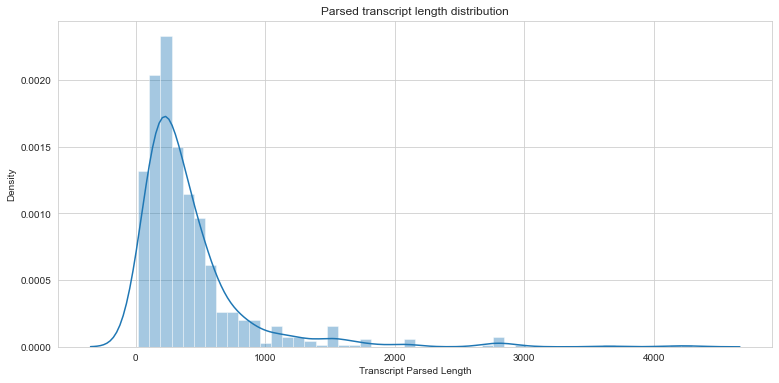

In [60]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Transcript Parsed Length']).set_title('Parsed transcript length distribution');

In [61]:
print(f'Dataset shape = {df_1.shape}')

Dataset shape = (763, 5)


In [62]:
# check for missing values in any column
df_1.isnull().any()

Transcript                  False
Topic                       False
Transcript Length           False
Transcript Parsed           False
Transcript Parsed Length    False
dtype: bool

In [63]:
# remove data points more than 1000 to reduce skewness
df_1 = df_1[df_1['Transcript Parsed Length'] <= 1000]
print(df_1.shape)

(708, 5)


In [64]:
df_1.reset_index(inplace=True)

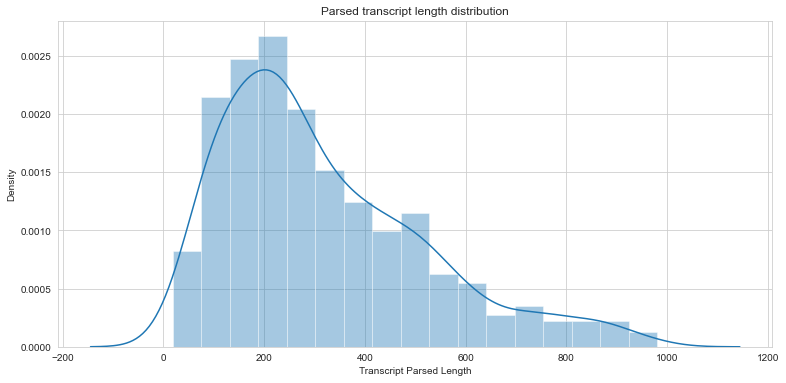

In [65]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Transcript Parsed Length']).set_title('Parsed transcript length distribution');

### 1.11 Make Vocabulary with High Frequency Words

In [85]:
all_words = list()
words_list = df_1['Transcript Parsed'].str.split().to_list()
for words in words_list:
    all_words.extend(words)

In [86]:
word_freq = dict()

for word in all_words:
    if word not in word_freq:
        word_freq[word] = 0
    word_freq[word] += 1
    
print(f'Size = {len(word_freq)}')

Size = 5216


In [87]:
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: -item[1]))

In [88]:
number_of_words_less_than_threshold_10 = 0
less_freq_words = list()
vocaubulary = list()
for word, freq in sorted_word_freq.items():
    if freq < 10:
        number_of_words_less_than_threshold_10 += 1
        less_freq_words.append(word)
    else:
        vocaubulary.append(word)
        
print(f'Number of words less than threshold 10 = {number_of_words_less_than_threshold_10}')

Number of words less than threshold 10 = 4414


<b> take words only more than or equal 10 occurences </b>

In [89]:
vocaubulary = set(vocaubulary)
print(f'Vocaubulary size = {len(vocaubulary)}')

vocaubulary_file = open('vocaubulary.txt','w+')
for word in vocaubulary:
    vocaubulary_file.write(f'{word}\n')
vocaubulary_file.close()

Vocaubulary size = 802


In [90]:
vocaubulary_list = list(vocaubulary)

In [91]:
size = len(df_1)

In [92]:
# remove all common words
for index in range(size):
    df_1.loc[index,'Transcript Parsed'] = " ".join(list(set(df_1.loc[index]['Transcript Parsed'].split()).intersection(vocaubulary_list)))

In [93]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  \
0  integer discourage visualize theres ya heres w...   
1  error trial hundreds twodigit estimate art rem...   
2  wish anytime oppose convert travel section int...   
3  hour fraction paper sixty quarter denominator ...   
4  land operation direction towards recap forward...   

   Transcript Parsed Length  Topic Codes  
0                       214            0  
1                       129            1  
2                       165            0  
3                       671            2  
4                        78            0

In [94]:
df_1['Transcript Parsed Length'] = df_1['Transcript Parsed'].str.len()

In [95]:
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  \
0  integer discourage visualize theres ya heres w...   
1  error trial hundreds twodigit estimate art rem...   
2  wish anytime oppose convert travel section int...   
3  hour fraction paper sixty quarter denominator ...   
4  land operation direction towards recap forward...   

   Transcript Parsed Length  Topic Codes  
0                       173            0  
1                        59            1  
2                       107            0  
3                       371            2  
4                        56            0

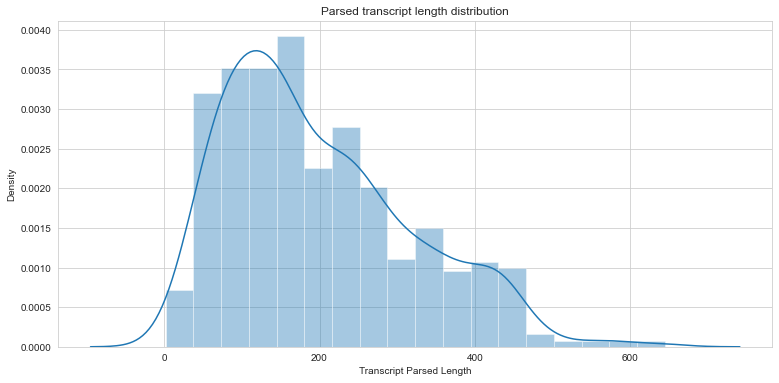

In [96]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_1['Transcript Parsed Length']).set_title('Parsed transcript length distribution');

In [97]:
# check for missing values in any column
df_1.isnull().any()

Transcript                  False
Topic                       False
Transcript Length           False
Transcript Parsed           False
Transcript Parsed Length    False
Topic Codes                 False
dtype: bool

In [98]:
# check if any data point contains parsed length as zero
df_1[df_1['Transcript Parsed Length'] == 0]

Empty DataFrame
Columns: [Transcript, Topic, Transcript Length, Transcript Parsed, Transcript Parsed Length, Topic Codes]
Index: []

## 2. Label coding

In [99]:
topic_codes = dict()
index = 0
for topic in list(df_1['Topic'].unique()):
    topic_codes[topic] = index
    index += 1

In [100]:
topic_codes

{'Directed Numbers': 0,
 'Operations of Whole Number': 1,
 'Sets': 2,
 'Factors and Multiplication': 3,
 'Angles': 4,
 'Symmetry': 5,
 'Indices': 6,
 'Perimeter': 7,
 'Algebra Expression': 8,
 'Number Patterns': 9}

In [103]:
df_1['Topic Codes'] = df_1['Topic']
df_1 = df_1.replace({'Topic Codes' : topic_codes})
#df_1.drop('index',axis=1,inplace=True)
df_1.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  \
0  integer discourage visualize theres ya heres w...   
1  error trial hundreds twodigit estimate art rem...   
2  wish anytime oppose convert travel section int...   
3  hour fraction paper sixty quarter denominator ...   
4  land operation direction towards recap forward...   

   Transcript Parsed Length  Topic Codes  
0                       173            0  
1                        59            1  
2                       107            0  
3                       371            2  
4                        56            0

In [104]:
# save pre-processed dataset
df_1.to_csv(r'pre-processed video transcripts dataset.csv', sep=',', encoding='utf-8', header='true')

In [105]:
# load pre-processed dataset
df_2 = pd.read_csv('pre-processed video transcripts dataset.csv')
df_2.head()

Unnamed: 0                                         Transcript  \
0           0  Hi, welcome to Math Antics. In our last video,...   
1           1  We're asked to compute 3,060 divided by 36. We...   
2           2  in this video we're going to focus on adding a...   
3           3  alright guys grab your papers and pencils get ...   
4           4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  \
0  integer discourage visualize theres ya heres w...   
1  error trial hundreds twodigit estimate art rem...   
2  wish anytime oppose convert travel section int...   
3  hour fraction paper sixty quarter denominator ...   
4  land operation direction towards recap forward...   

   Transcript Parsed Length  Topic Codes  
0                       173            0  
1                        59            1  
2                       107            0  
3                       371            2  
4                        56            0

In [106]:
df_2.drop('Unnamed: 0',axis=1,inplace=True)

In [107]:
df_2.head()

Transcript  \
0  Hi, welcome to Math Antics. In our last video,...   
1  We're asked to compute 3,060 divided by 36. We...   
2  in this video we're going to focus on adding a...   
3  alright guys grab your papers and pencils get ...   
4  With all of the rules and scenarios, rememberi...   

                        Topic  Transcript Length  \
0            Directed Numbers              10411   
1  Operations of Whole Number               3949   
2            Directed Numbers               7868   
3                        Sets               6643   
4            Directed Numbers               1372   

                                   Transcript Parsed  \
0  integer discourage visualize theres ya heres w...   
1  error trial hundreds twodigit estimate art rem...   
2  wish anytime oppose convert travel section int...   
3  hour fraction paper sixty quarter denominator ...   
4  land operation direction towards recap forward...   

   Transcript Parsed Length  Topic Codes  
0                       173            0  
1                        59            1  
2                       107            0  
3                       371            2  
4                        56            0

## 3. Train - test split

In [108]:
X_train, X_test, y_train, y_test = train_test_split(df_2['Transcript Parsed'], 
                                                    df_2['Topic Codes'], 
                                                    test_size = 0.15, 
                                                    random_state = 8)

In [109]:
print(f'X_train shape = {X_train.shape}, X_test shape = {X_test.shape}, y_train shape = {y_train.shape}, y_test shape = {y_test.shape}')

X_train shape = (601,), X_test shape = (107,), y_train shape = (601,), y_test shape = (107,)


In [110]:
X_train.head()

589    combine formula separately breadth simplify gl...
335    plug forth elements differ lowest integer posi...
53     proper track basics forth million commas kinda...
371    calculator divisibility cross fraction fortuna...
594    rational numerator undefined fraction integers...
Name: Transcript Parsed, dtype: object

In [111]:
y_train.head()

589    7
335    2
53     9
371    3
594    1
Name: Topic Codes, dtype: int64

## 4. Text representation

We have various options:

* Count Vectors as features
* TF-IDF Vectors as features
* Word Embeddings as features
* Text / NLP based features
* Topic Models as features

We'll use **Count Vectors** as features.

In [112]:
from sklearn.feature_extraction.text import CountVectorizer

In [123]:
vectorizer = CountVectorizer()
features_train = vectorizer.fit_transform(X_train)
labels_train = features_train
print(features_train.shape)

features_test = vectorizer.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(601, 796)
(107, 796)


In [124]:
len(vectorizer.vocabulary_)

796

In [126]:
# X_train
with open('Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('Pickles/df_2.pickle', 'wb') as output:
    pickle.dump(df_2, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('Pickles/vectorizer.pickle', 'wb') as output:
    pickle.dump(vectorizer, output)